## **Sistema de Predicción de Precios Automotrices: Modelado y Despliegue en Streamlit**

En este notebook se desarrolla una aplicación interactiva utilizando **Streamlit**, cuyo objetivo es permitir a los usuarios estimar el precio de vehículos usados a partir de un modelo de Machine Learning previamente entrenado.

La aplicación integra el pipeline completo de preprocesamiento y el modelo predictivo (XGBoost), permitiendo al usuario cargar un archivo en formato CSV con las variables necesarias y obtener de manera automática una estimación del precio de mercado.

---

### **Objetivo**

Traducir el modelo predictivo desarrollado en etapas anteriores a una herramienta práctica e interactiva, enfocada en un entorno real de negocio dentro del mercado automotriz.

Esta aplicación permite:

- Cargar datos estructurados en formato CSV.
- Validar automáticamente las columnas requeridas.
- Aplicar el preprocesador entrenado.
- Generar predicciones de precio.
- Visualizar estadísticas resumen.
- Descargar los resultados con las estimaciones incluidas.

---

### **Variables Utilizadas**

El modelo utiliza las siguientes variables predictoras:

- `year`
- `manufacturer`
- `condition`
- `cylinders`
- `fuel`
- `odometer`
- `title_status`
- `transmission`
- `drive`
- `type`
- `paint_color`

Estas variables fueron previamente seleccionadas y limpiadas durante el proceso de análisis exploratorio y preprocesamiento de datos.

---

### **Modelo Implementado**

El modelo desplegado corresponde a un **XGBoost Regressor** integrado dentro de un `Pipeline` de Scikit-Learn, lo que garantiza:

- Consistencia en el tratamiento de variables.
- Reproducibilidad.
- Portabilidad del modelo mediante serialización con `joblib`.

El modelo presenta un desempeño aproximado de:

- **R² ≈ 0.80**
- **MAE ≈ $2,900 USD**

Lo que indica una buena capacidad para capturar la variabilidad del mercado de autos usados.

---

### **Valor de Negocio**

Esta aplicación demuestra la transición desde un análisis exploratorio y modelado estadístico hacia una solución aplicada que puede ser utilizada por:

- Concesionarios de autos usados.
- Analistas de mercado automotriz.
- Plataformas de compra-venta.
- Usuarios interesados en estimar el valor de su vehículo.

Representa un paso fundamental hacia la implementación de modelos de Machine Learning en entornos productivos.

---

### **Tecnologías Utilizadas**

- Python
- Pandas
- Scikit-Learn
- XGBoost
- Joblib
- Streamlit

---

### **Conclusión**

Este notebook consolida el ciclo completo del proyecto:

1. Limpieza y preprocesamiento de datos.
2. Entrenamiento y comparación de modelos.
3. Selección del modelo óptimo.
4. Despliegue en una aplicación interactiva.

Con ello, se demuestra no solo capacidad técnica en modelado, sino también en implementación práctica orientada a negocio.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

## **Cargar modelo**

In [ ]:
model = joblib.load('/content/model.pkl')

In [ ]:
model.feature_names_in_

array(['year', 'manufacturer', 'condition', 'cylinders', 'fuel',
       'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color'], dtype=object)

In [ ]:
xgb_model = model.named_steps['model']
importances = xgb_model.feature_importances_

In [ ]:
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

In [ ]:
df_feature = pd.DataFrame({'features':feature_names, 'importances':importances})

In [ ]:
df_feature['features_group'] = df_feature['features'].str.split('__').str[-1]

In [ ]:
df_feature['features_group'] = df_feature['features_group'].str.split('_').str[0]

In [ ]:


grouped_importance = (
    df_feature
    .groupby('features_group')['importances']
    .sum()
    .sort_values(ascending=False)
)

grouped_importance


,importances
features_group,
manufacturer,0.410344
drive,0.118951
type,0.108614
cylinders,0.090221
year,0.086339
fuel,0.077665
condition,0.032203
title,0.032171
paint,0.016426


In [ ]:
grouped_importance

,importances
features_group,
manufacturer,0.410344
drive,0.118951
type,0.108614
cylinders,0.090221
year,0.086339
fuel,0.077665
condition,0.032203
title,0.032171
paint,0.016426


## **Interpretación de Importancia de Variables – XGBoost**

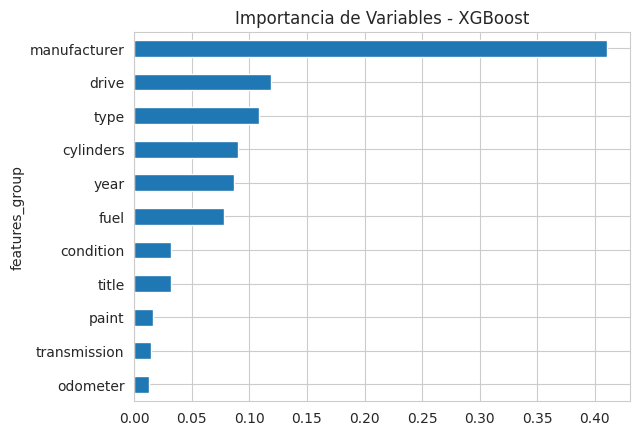

In [ ]:
sns.set_style('whitegrid')

grouped_importance.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Importancia de Variables - XGBoost")
plt.show()



El modelo basado en XGBoost identifica que la **marca del vehículo (manufacturer)** representa aproximadamente el 41% de la importancia total, consolidándose como el principal determinante del precio en el mercado de autos usados. Le siguen variables estructurales como el sistema de tracción (drive), el tipo de vehículo (type) y la configuración del motor (cylinders), lo que sugiere que el valor percibido del vehículo está fuertemente asociado a su segmento, posicionamiento de marca y características mecánicas.

Aunque el **kilometraje (odometer)** presenta una correlación negativa considerable con el precio (-0.63), su importancia relativa dentro del modelo resulta baja. Esto puede explicarse por la alta relación estructural entre el año del vehículo (year) y su kilometraje, ya que los autos más recientes tienden naturalmente a tener menor uso. En este sentido, el modelo puede estar capturando indirectamente el efecto del desgaste a través de la variable year, reduciendo la contribución marginal del odometer.

Además, los modelos basados en árboles tienden a aprovechar con mayor eficiencia variables categóricas que generan particiones claras (como manufacturer o type), lo que puede absorber parte de la señal predictiva de variables continuas como el kilometraje.

En términos generales, el análisis sugiere que el precio en este mercado de autos usados está más influenciado por factores estructurales y de posicionamiento del vehículo que por variables estrictamente asociadas al uso, aunque estas últimas siguen teniendo un impacto estadísticamente relevante.


## **Aplicación Interactiva de Predicción de Precios de Autos Usados**

In [ ]:
# !pip install streamlit

In [ ]:
import streamlit as st
import pandas as pd
import joblib

# -------------------------
# Configuración general
# -------------------------
st.set_page_config(page_title="Car Price Predictor", layout="wide")

st.title("🚗 Predicción de Precio de Autos Usados")
st.markdown(
    """
    Sube un archivo CSV con las siguientes variables:

    - year
    - manufacturer
    - condition
    - cylinders
    - fuel
    - odometer
    - title_status
    - transmission
    - drive
    - type
    - paint_color
    """
)

# -------------------------
# Cargar modelo
# -------------------------
@st.cache_resource
def load_model():
    model = joblib.load("model.pkl")
    return model

model = load_model()

# -------------------------
# Subir archivo
# -------------------------
uploaded_file = st.file_uploader("Sube tu archivo CSV", type=["csv"])

if uploaded_file is not None:

    try:
        df = pd.read_csv(uploaded_file)

        st.subheader("Vista previa del dataset")
        st.dataframe(df.head())

        required_columns = [
            'year', 'manufacturer', 'condition', 'cylinders', 'fuel',
            'odometer', 'title_status', 'transmission',
            'drive', 'type', 'paint_color'
        ]

        # Validar columnas
        if not all(col in df.columns for col in required_columns):
            st.error("❌ El archivo no contiene las columnas necesarias.")
        else:
            st.success("✅ Columnas validadas correctamente.")

            # Predicciones
            predictions = model.predict(df)

            df["predicted_price"] = predictions

            st.subheader("Resultados con Predicción")
            st.dataframe(df.head())

            # Métricas resumen
            st.subheader("Resumen de Predicciones")
            st.write(f"Precio promedio estimado: ${df['predicted_price'].mean():,.2f}")
            st.write(f"Precio máximo estimado: ${df['predicted_price'].max():,.2f}")
            st.write(f"Precio mínimo estimado: ${df['predicted_price'].min():,.2f}")

            # Descargar resultado
            csv = df.to_csv(index=False).encode('utf-8')
            st.download_button(
                label="📥 Descargar archivo con predicciones",
                data=csv,
                file_name="predicciones_autos.csv",
                mime="text/csv"
            )

    except Exception as e:
        st.error(f"Ocurrió un error: {e}")


2026-02-11 17:25:03.688 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 17:25:03.688 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 17:25:03.853 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2026-02-11 17:25:03.854 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 17:25:03.856 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 17:25:03.857 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-11 17:25:03.860 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn